# Diabetic Retinopathy Detection

In [1]:
import cv2,os
data_path='dataset/'
categories=os.listdir(data_path)

labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary
print(label_dict)
print(categories)
print(labels)

{'diabetic_retinopathy': 0, 'glaucoma': 1, 'normal': 2}
['diabetic_retinopathy', 'glaucoma', 'normal']
[0, 1, 2]


In [2]:
img_size_x=224
img_size_y=224
data=[]
label=[]

for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
            resized=cv2.resize(gray,(img_size_x,img_size_y))
            #resizing the image  into 224 x 224, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            label.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)
        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

# Recale and assign  catagorical labels

In [3]:
import numpy as np
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size_x,img_size_y,1))
label=np.array(label)
from tensorflow.keras.utils import to_categorical
new_label=to_categorical(label)

# CNN Model

In [4]:
data.shape

(3179, 224, 224, 1)

In [5]:
data.shape[1:]

(224, 224, 1)

In [6]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,1), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(3, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5), loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 8)       80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 8)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 111, 111, 8)       32        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 16)        0         
 g2D)                                                            
                                                        

# Splitting data into traning and testing

In [8]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data,new_label,test_size=0.1)

In [9]:
history=model.fit(x_train,y_train,epochs=10,validation_split=0.2)

Epoch 1/10



72/72 [==============================] - 22s 223ms/step - loss: 0.8148 - acc: 0.7382 - val_loss: 3.9503 - val_acc: 0.3455
Epoch 2/10
72/72 [==============================] - 14s 198ms/step - loss: 0.4183 - acc: 0.8230 - val_loss: 3.8767 - val_acc: 0.3455
Epoch 3/10
72/72 [==============================] - 14s 200ms/step - loss: 0.3479 - acc: 0.8518 - val_loss: 6.0234 - val_acc: 0.3455
Epoch 4/10
72/72 [==============================] - 14s 199ms/step - loss: 0.2945 - acc: 0.8615 - val_loss: 1.7853 - val_acc: 0.4660
Epoch 5/10
72/72 [==============================] - 14s 200ms/step - loss: 0.3031 - acc: 0.8658 - val_loss: 1.5421 - val_acc: 0.4887
Epoch 6/10
72/72 [==============================] - 14s 201ms/step - loss: 0.2700 - acc: 0.8737 - val_loss: 0.8936 - val_acc: 0.5724
Epoch 7/10
72/72 [==============================] - 14s 197ms/step - loss: 0.2662 - acc: 0.8772 - val_loss: 0.4843 - val_acc: 0.8272
Epoch 8/10
72/72 [==============================] - 14s 196ms/step - loss: 0.238

In [10]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


# Model evaluation
y_pred = model.predict(x_test)

# Convert one-hot encoded labels back to categorical labels
y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Confusion matrix
conf_mat = confusion_matrix(y_true_labels, y_pred_labels)
print("Confusion Matrix:")
print(conf_mat)

# Specificity (True Negative Rate), Precision, Recall, and F1 Score for each class
for i in range(conf_mat.shape[0]):
    true_negative = np.sum(conf_mat) - np.sum(conf_mat[i, :]) - np.sum(conf_mat[:, i]) + conf_mat[i, i]
    false_positive = np.sum(conf_mat[:, i]) - conf_mat[i, i]
    false_negative = np.sum(conf_mat[i, :]) - conf_mat[i, i]
    true_positive = conf_mat[i, i]

    specificity = true_negative / (true_negative + false_positive)
    
    # Check for zero denominators in precision and recall
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    
    # Check for zero denominators in F1 score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\nMetrics for Class {i}:")
    print("Specificity (True Negative Rate): {:.4f}".format(specificity))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1 Score: {:.4f}".format(f1))



10/10 [==============================] - 1s 57ms/step
Confusion Matrix:
[[102   0   0]
 [  1  81  15]
 [  1   7 111]]

Metrics for Class 0:
Specificity (True Negative Rate): 0.9907
Precision: 0.9808
Recall: 1.0000
F1 Score: 0.9903

Metrics for Class 1:
Specificity (True Negative Rate): 0.9683
Precision: 0.9205
Recall: 0.8351
F1 Score: 0.8757

Metrics for Class 2:
Specificity (True Negative Rate): 0.9246
Precision: 0.8810
Recall: 0.9328
F1 Score: 0.9061


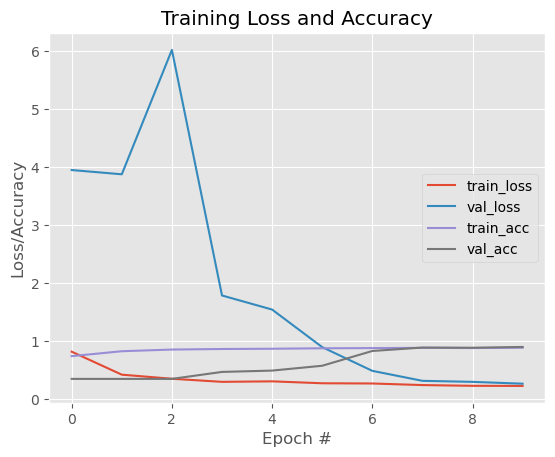

In [12]:
import matplotlib.pyplot as plt

# # plot the training loss and accuracy
N = 10 #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")

In [13]:
model.save('model.h5')

C:\Users\dgoya\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
import numpy as np
from keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
import cv2

dic = {0 : 'diabetic_retinopathy', 1 : 'glaucoma', 2 : 'normal'}

img_size_x=224
img_size_y=224
model = load_model('model.h5')

def predict_label(img_path):
    img=cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
    resized=cv2.resize(gray,(img_size_x,img_size_y)) 
    i = img_to_array(resized)/255.0
    i = i.reshape(1,img_size_x,img_size_y,1)
    predict_x=model.predict(i) 
    p=np.argmax(predict_x,axis=1)
    return dic[p[0]]

img_path = "dataset\\glaucoma\\_10_1472170.jpg"
p = predict_label(img_path)
print(p)

1/1 [==============================] - 0s 418ms/step
glaucoma
